## Dataset: Thyroid Disease (ANN-Thyroid)

- **Nome**: Thyroid Disease – ann-thyroid  
- **Sorgente**: UCI Machine Learning Repository – sezione *Thyroid Disease*  
- **Link**: https://archive.ics.uci.edu/dataset/102/thyroid+disease  
- **Numero di campioni (grezzi)**: 7200 istanze (3772 train + 3428 test nella versione originale UCI)  
- **Numero di campioni dopo pulizia**: 7129 istanze (`df_clean`)  
- **Numero di feature**: 21 variabili di input (15 binarie, 6 continue)  
- **Label / task**:  
  - 3 classi:  
    - `1` = normal  
    - `2` = hyperthyroid  
    - `3` = hypothyroid  
  - **Task**: classificazione multiclasse (3-class classification)


Shape raw: (7200, 22)  -> clean: (7129, 22)
Distribuzione etichette:
 label
1     166
2     368
3    6595
Name: count, dtype: int64


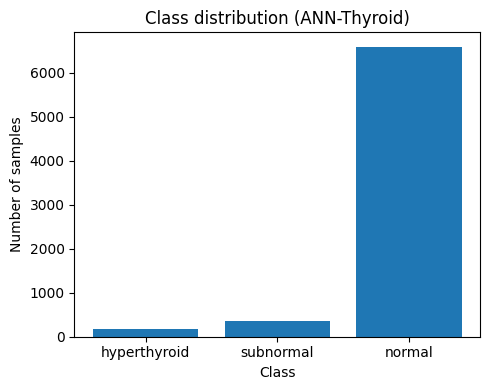

((7129, 21), (7129,))

In [13]:
# Load & Clean: ann-thyroid (UCI, zero-missing)
# task di classificazione multiclasse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_selection import SelectKBest, f_classif

TRAIN_PATH = "/content/ann-train.data"
TEST_PATH  = "/content/ann-test.data"

# Cartella per salvare le figure
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# nomi colonne: 21 feature + label
colnames = [f"x{i}" for i in range(1, 22)] + ["label"]

def load_ann(path):
    return pd.read_csv(
        path,
        sep=r"\s+",
        header=None,
        names=colnames,
        na_values=["?"],
        engine="python"
    )

# carica e concatena train+test UCI
df = pd.concat(
    [load_ann(TRAIN_PATH), load_ann(TEST_PATH)],
    ignore_index=True
)

# cast numerico dove possibile (le non-numeriche diventano NaN e poi le rimuoviamo)
for c in df.columns[:-1]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# solo label valide e righe senza alcun NaN
df = df[df["label"].isin([1, 2, 3])]
df_clean = df.dropna(axis=0).drop_duplicates().reset_index(drop=True)

print("Shape raw:", df.shape, " -> clean:", df_clean.shape)
print("Distribuzione etichette:\n", df_clean["label"].value_counts().sort_index())

# mappatura etichette leggibili (DEFINITA PRIMA DI USARLA)
label_map = {1: "hyperthyroid", 2: "subnormal", 3: "normal"}

# conteggio delle classi
class_counts = df_clean["label"].value_counts().sort_index()
class_names = [label_map[int(c)] for c in class_counts.index]

plt.figure(figsize=(5, 4))
plt.bar(class_names, class_counts.values)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class distribution (ANN-Thyroid)")
plt.tight_layout()

# salva il grafico su file
plt.savefig(RESULTS_DIR / "class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# colonna opzionale con label leggibili (non usata come feature)
df_clean["label_name"] = df_clean["label"].map(label_map)

# X, y per il resto del notebook
X = df_clean.drop(columns=["label", "label_name"], errors="ignore").values
y = df_clean["label"].values

# check "zero-missing"
assert not pd.isna(X).any(), "Ci sono ancora NaN in X"
assert not pd.isna(y).any(), "Ci sono ancora NaN in y"

X.shape, y.shape


In [14]:
n_raw = df.shape[0]
n_clean = df_clean.shape[0]

# numero di feature effettivamente usate nei modelli
n_features = X.shape[1]

print("Campioni grezzi:", n_raw)
print("Campioni dopo pulizia:", n_clean)
print("Numero di feature:", n_features)

Campioni grezzi: 7200
Campioni dopo pulizia: 7129
Numero di feature: 21


In [15]:
#EDA Exploratory Data Analysis
df_work = pd.DataFrame(X, columns=[f"x{i}" for i in range(1, 22)])
df_work["label"] = y
display(df_work.describe())

# frequenze assolute e relative (in %)
abs_counts = df_work["label"].value_counts().sort_index()
rel_counts = (df_work["label"].value_counts(normalize=True)
              .sort_index().mul(100).round(2))
display(abs_counts)
display(rel_counts)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x13,x14,x15,x16,x17,x18,x19,x20,x21,label
count,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,...,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000
mean,0.521347,0.306775,0.131856,0.015570,0.012765,0.038715,0.010941,0.014167,0.016973,0.066208,...,0.008276,0.025810,0.000140,0.049376,0.004891,0.019971,0.109415,0.097829,0.113225,2.901810
std,0.189419,0.461188,0.338358,0.123814,0.112266,0.192929,0.104034,0.118189,0.129179,0.248664,...,0.090602,0.158579,0.011844,0.216667,0.023092,0.007576,0.036144,0.019179,0.036273,0.367612
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,0.002000,0.017000,0.002000,1.000000
25%,0.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000700,0.017000,0.089000,0.087000,0.094000,3.000000
50%,0.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001700,0.020100,0.106000,0.096000,0.111000,3.000000
75%,0.680000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002700,0.022000,0.125000,0.104000,0.127000,3.000000
max,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.530000,0.180000,0.600000,0.233000,0.642000,3.000000


,count
label,
1,166
2,368
3,6595


,proportion
label,
1,2.33
2,5.16
3,92.51


In [16]:
# blocco 2: numeri per classe con numpy
import numpy as np
classes, counts = np.unique(y, return_counts=True)
list(zip(classes, counts))


[(np.int64(1), np.int64(166)),
 (np.int64(2), np.int64(368)),
 (np.int64(3), np.int64(6595))]

In [17]:
# Split 60/20/20 (stratificato)
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_valid
)  # 60/20/20 complessivo

X_train.shape, X_valid.shape, X_test.shape


((4277, 21), (1426, 21), (1426, 21))

In [18]:
# pipeline + griglie
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipelines_and_grids = []

# 1) Gaussian Naive Bayes
pipelines_and_grids.append((
    Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())]),
    {'clf__var_smoothing': [1e-9, 1e-8, 1e-7]},
    'GaussianNB'
))

# 2) Softmax (Logistic Regression multinomiale) + SelectKBest dentro la pipeline
pipe_softmax = Pipeline([
    ('scaler', StandardScaler()),
    ('sel', SelectKBest(score_func=f_classif)),     # selezione supervisionata
    ('clf', LogisticRegression(multi_class='multinomial', max_iter=2000, solver='lbfgs'))
])
grid_softmax = {
    'sel__k': [10, 15, 'all'],                      # confronta subset vs tutte le 21
    'clf__C': [0.1, 1.0, 10.0],
    'clf__class_weight': [None, 'balanced']
}
pipelines_and_grids.append((pipe_softmax, grid_softmax, 'SoftmaxRegression'))


# 3) Decision Tree
pipelines_and_grids.append((
    Pipeline([('clf', DecisionTreeClassifier(random_state=42))]),
    {'clf__max_depth': [None, 5, 10, 20],
     'clf__min_samples_split': [2, 10, 20]},
    'DecisionTree'
))

# 4) Random Forest
pipelines_and_grids.append((
    Pipeline([('clf', RandomForestClassifier(random_state=42))]),
    {'clf__n_estimators': [200, 400],
     'clf__max_depth': [None, 10, 20],
     'clf__min_samples_split': [2, 10]},
    'RandomForest'
))

# 5) Linear SVM + supervised feature selection
pipe_svm_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('sel', SelectKBest(score_func=f_classif)),
    ('clf', SVC(kernel='linear', probability=True, random_state=42))
])
grid_svm_linear = {
    'sel__k': [10, 15, 'all'],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__class_weight': [None, 'balanced']
}
pipelines_and_grids = [pg for pg in pipelines_and_grids if pg[2] != 'SVM_Linear']
pipelines_and_grids.append((pipe_svm_linear, grid_svm_linear, 'SVM_Linear'))


# 6) SVM RBF
pipelines_and_grids.append((
    Pipeline([('scaler', StandardScaler()),
              ('clf', SVC(kernel='rbf', probability=True, random_state=42))]),
    {'clf__C': [0.1, 1.0, 10.0],
     'clf__gamma': ['scale', 0.01, 0.001],
     'clf__class_weight': [None, 'balanced']},
    'SVM_RBF'
))


In [19]:
# GridSearchCV con multi-metrica (refit su macro-F1)
import pandas as pd
from time import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def _eval(est, X, y):
    """Ritorna le metriche principali per l'estimatore est su (X, y)."""
    yhat = est.predict(X)
    return {
        'accuracy': accuracy_score(y, yhat),
        'f1_macro': f1_score(y, yhat, average='macro'),
        'precision_macro': precision_score(y, yhat, average='macro'),
        'recall_macro': recall_score(y, yhat, average='macro'),
    }

all_results = []
best_estimators = {}

for pipe, grid, name in pipelines_and_grids:
    print(f"\n>>> {name}")
    gs = GridSearchCV(
        pipe, grid, cv=cv, n_jobs=-1, verbose=0,
        scoring={'acc': 'accuracy', 'f1m': 'f1_macro'},
        refit='f1m'  # iperparametri che massimizzano macro-F1
    )

    t0 = time()
    gs.fit(X_train, y_train)
    elapsed = time() - t0

    print(
        f"Best params: {gs.best_params_} | "
        f"CV best macro-F1 {gs.best_score_:.4f} | "
        f"Time: {elapsed:.1f}s"
    )

    best_estimators[name] = gs.best_estimator_

    # metriche su train / valid / test
    metrics_train = _eval(gs.best_estimator_, X_train, y_train)
    metrics_val   = _eval(gs.best_estimator_, X_valid, y_valid)
    metrics_test  = _eval(gs.best_estimator_, X_test,  y_test)

    all_results.append({
        'name': name,
        'cv_best_macroF1': gs.best_score_,

        'train_accuracy':  metrics_train['accuracy'],
        'train_macroF1':   metrics_train['f1_macro'],
        'train_precision': metrics_train['precision_macro'],
        'train_recall':    metrics_train['recall_macro'],

        'valid_accuracy':  metrics_val['accuracy'],
        'valid_macroF1':   metrics_val['f1_macro'],
        'valid_precision': metrics_val['precision_macro'],
        'valid_recall':    metrics_val['recall_macro'],

        'test_accuracy':   metrics_test['accuracy'],
        'test_macroF1':    metrics_test['f1_macro'],
        'test_precision':  metrics_test['precision_macro'],
        'test_recall':     metrics_test['recall_macro'],

        'grid_time_sec':   elapsed
    })

results_df = pd.DataFrame(all_results).sort_values(
    by=['valid_macroF1', 'test_macroF1'],
    ascending=False
)
display(results_df)



>>> GaussianNB
Best params: {'clf__var_smoothing': 1e-07} | CV best macro-F1 0.1065 | Time: 4.7s

>>> SoftmaxRegression


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best params: {'clf__C': 10.0, 'clf__class_weight': 'balanced', 'sel__k': 15} | CV best macro-F1 0.8569 | Time: 6.8s

>>> DecisionTree
Best params: {'clf__max_depth': 5, 'clf__min_samples_split': 10} | CV best macro-F1 0.9824 | Time: 0.5s

>>> RandomForest
Best params: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200} | CV best macro-F1 0.9737 | Time: 54.8s

>>> SVM_Linear


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params: {'clf__C': 10.0, 'clf__class_weight': None, 'sel__k': 15} | CV best macro-F1 0.8666 | Time: 104.6s

>>> SVM_RBF
Best params: {'clf__C': 10.0, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale'} | CV best macro-F1 0.8359 | Time: 182.0s


,name,cv_best_macroF1,train_accuracy,train_macroF1,train_precision,train_recall,valid_accuracy,valid_macroF1,valid_precision,valid_recall,test_accuracy,test_macroF1,test_precision,test_recall,grid_time_sec
2,DecisionTree,0.982414,0.996727,0.985466,0.972687,0.998821,0.995792,0.972819,0.962457,0.984384,0.995792,0.980368,0.972551,0.988635,0.532743
3,RandomForest,0.973680,1.000000,1.000000,1.000000,1.000000,0.994390,0.962904,0.952944,0.974030,0.997896,0.985202,0.981127,0.989394,54.799464
1,SoftmaxRegression,0.856944,0.967033,0.868569,0.789293,0.988122,0.969846,0.860057,0.787867,0.975033,0.965638,0.860731,0.784733,0.973517,6.789086
4,SVM_Linear,0.866602,0.973813,0.881839,0.929722,0.850099,0.969846,0.847684,0.897376,0.825093,0.967041,0.840906,0.906180,0.805513,104.609258
5,SVM_RBF,0.835886,0.976385,0.917031,0.861127,0.991492,0.948808,0.789959,0.739812,0.864499,0.954418,0.822666,0.779680,0.893376,181.991864
0,GaussianNB,0.106492,0.114099,0.108841,0.366362,0.507291,0.110098,0.104089,0.357998,0.468275,0.123422,0.116207,0.365436,0.514033,4.740499


In [20]:
# salva risultati e scegli per validation
import pandas as pd, os
from pathlib import Path

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# salva la tabella comparativa
results_df.to_csv(RESULTS_DIR / "model_comparison.csv", index=False)

# scegli il best per validation (metodo corretto) e il best per test (per confronto)
best_by_valid = results_df.sort_values("valid_macroF1", ascending=False).iloc[0]["name"]
best_by_test  = results_df.sort_values("test_macroF1",  ascending=False).iloc[0]["name"]
best_by_valid, best_by_test


('DecisionTree', 'RandomForest')


Model: GaussianNB


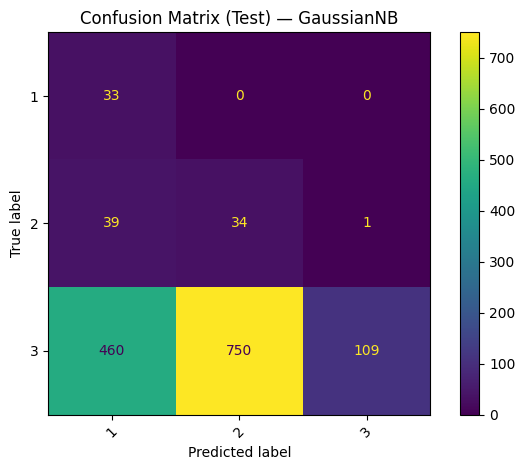

Macro AUC (validation) — GaussianNB: 0.7322


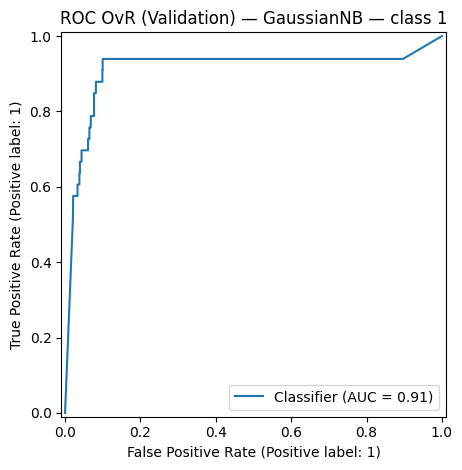

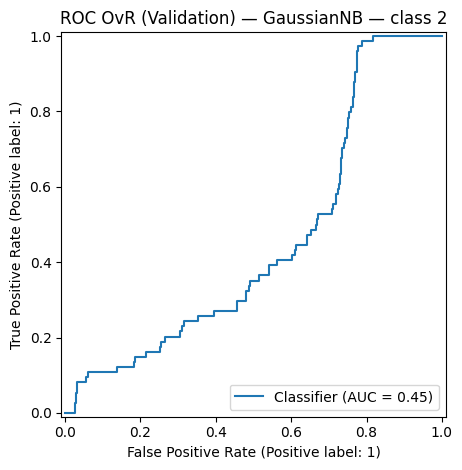

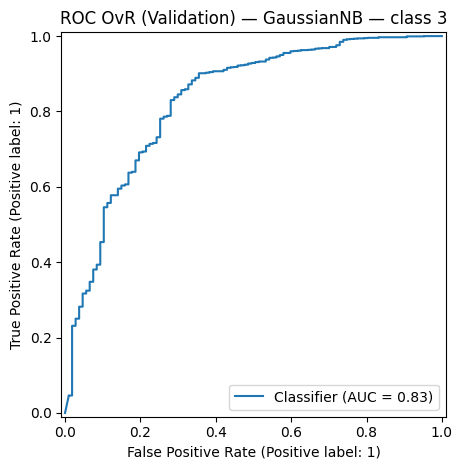


Model: SoftmaxRegression


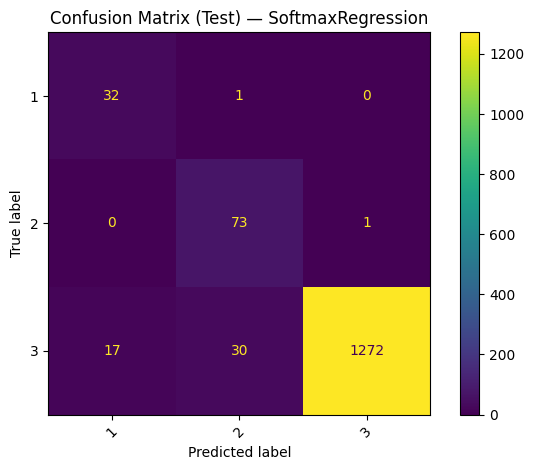

Macro AUC (validation) — SoftmaxRegression: 0.9918


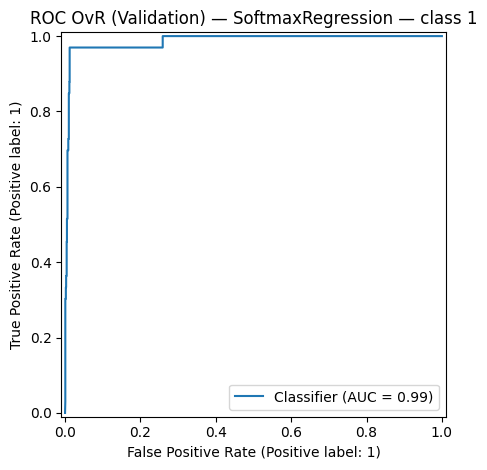

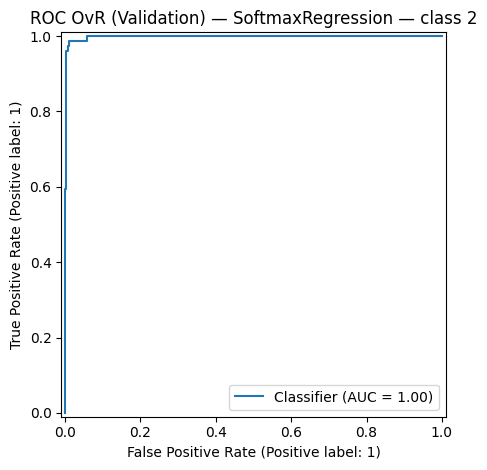

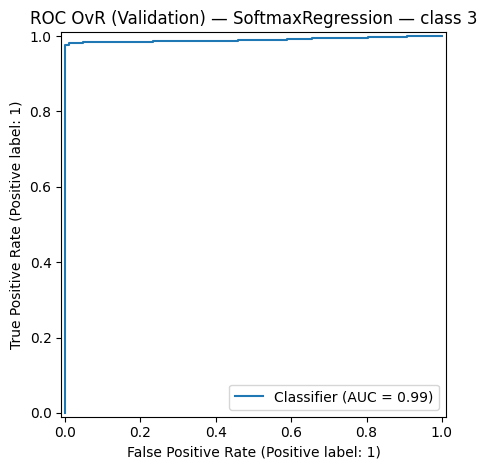


Model: DecisionTree


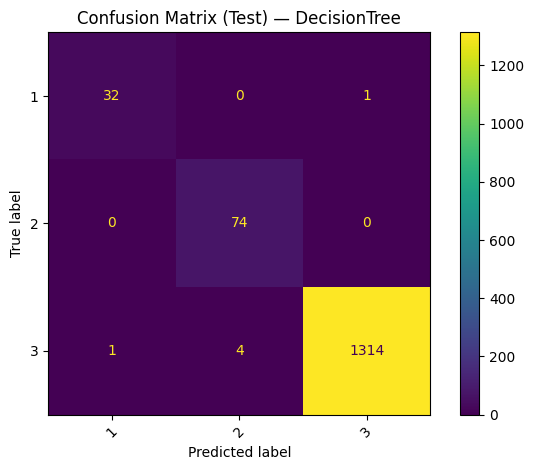

Macro AUC (validation) — DecisionTree: 0.9886


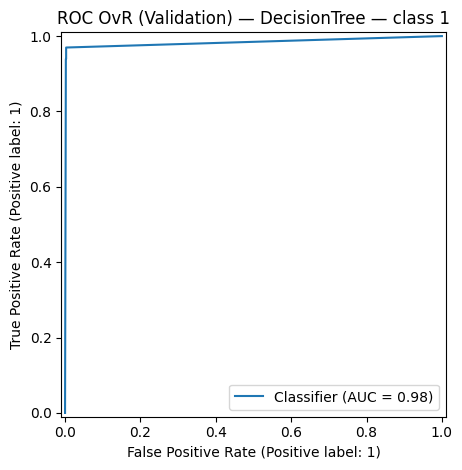

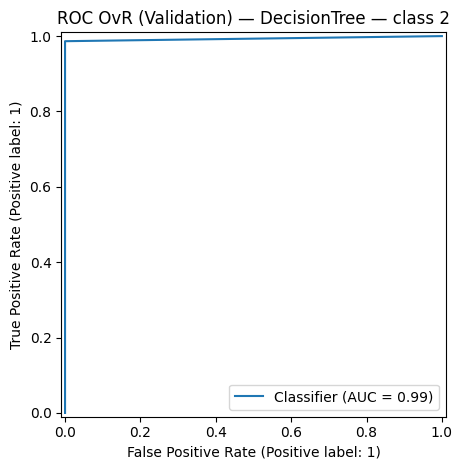

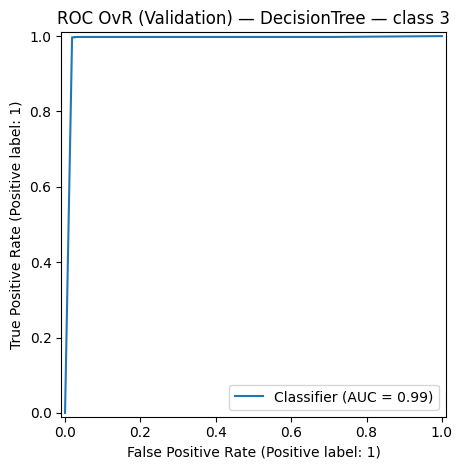


Model: RandomForest


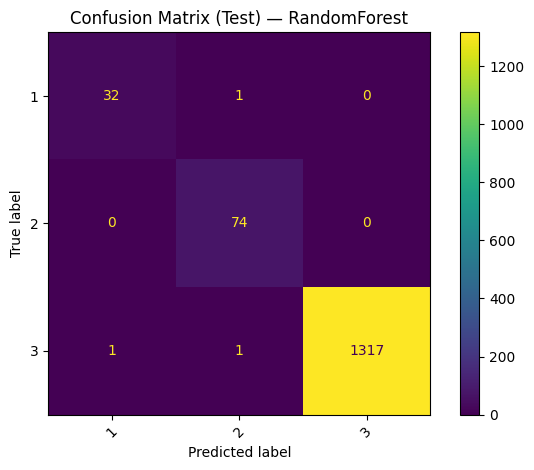

Macro AUC (validation) — RandomForest: 0.9992


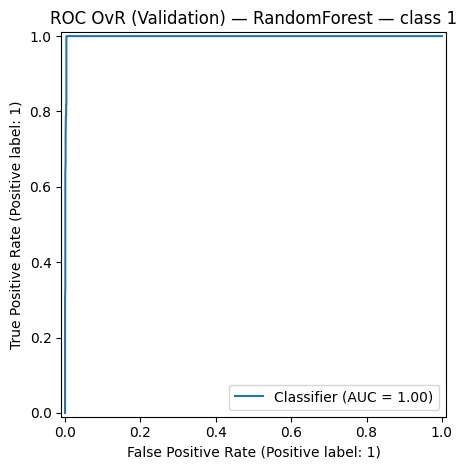

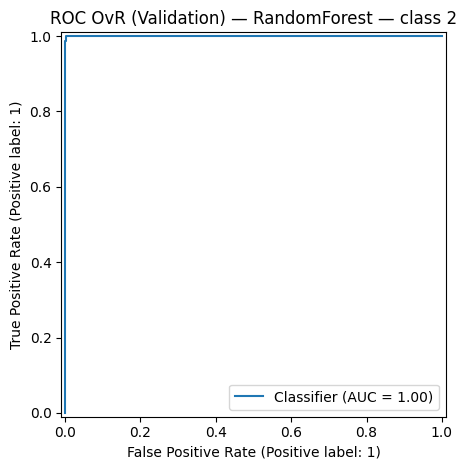

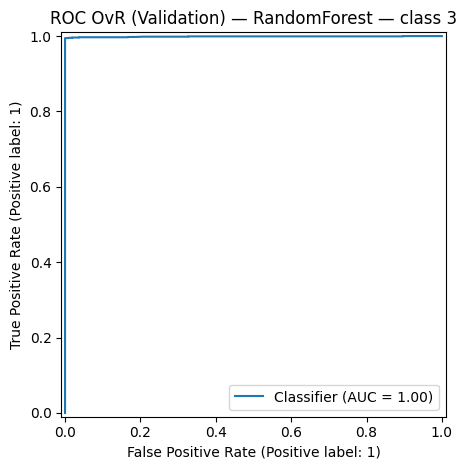


Model: SVM_Linear


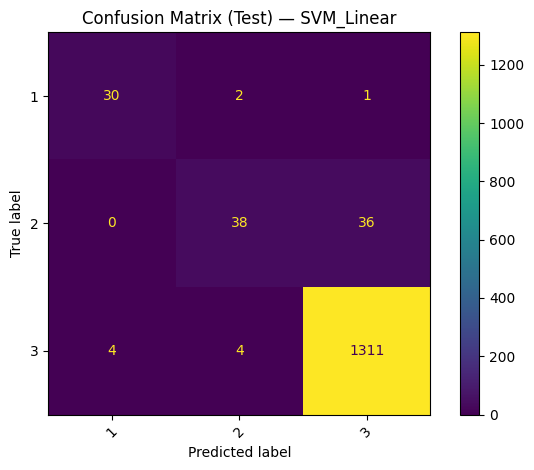

Macro AUC (validation) — SVM_Linear: 0.9953


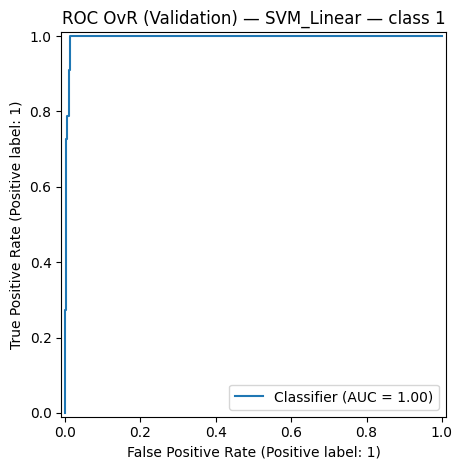

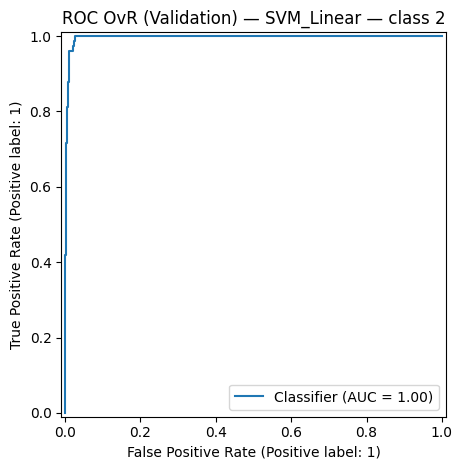

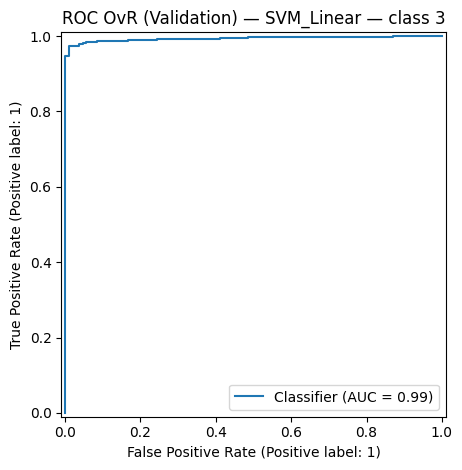


Model: SVM_RBF


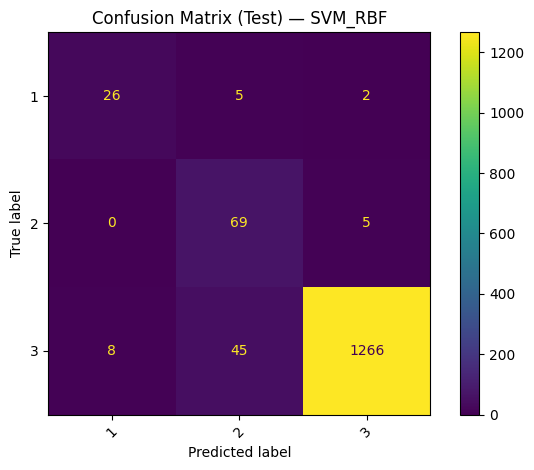

Macro AUC (validation) — SVM_RBF: 0.9889


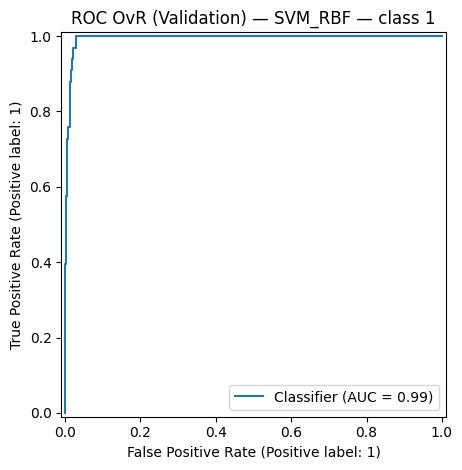

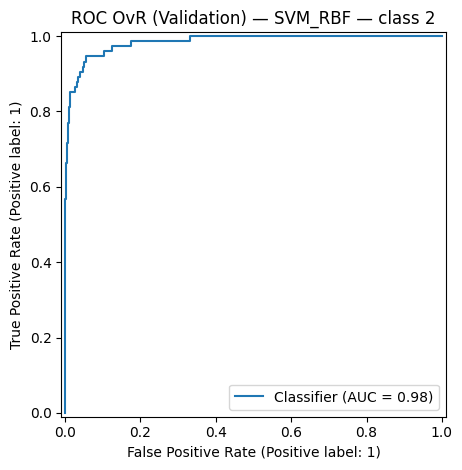

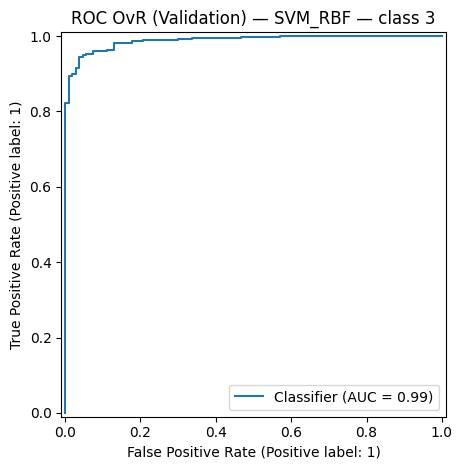

In [21]:
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Cartella per salvare le figure
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# Modelli per le visualizzazioni
models_of_interest = [
    "GaussianNB",
    "SoftmaxRegression",
    "DecisionTree",
    "RandomForest",
    "SVM_Linear",
    "SVM_RBF",
]

labels = np.sort(np.unique(y_train))
y_valid_bin = label_binarize(y_valid, classes=labels)

for name in models_of_interest:
    print("\n==============================")
    print(f"Model: {name}")
    est = best_estimators[name]

    # --- Confusion matrix (test) ---
    y_pred_test = est.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
    disp.plot(values_format='d', xticks_rotation=45)
    plt.title(f'Confusion Matrix (Test) — {name}')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'cm_test_{name}.png', dpi=150)
    plt.show()

    # --- ROC + macro-AUC (validation) ---
    if hasattr(est, "predict_proba"):
        y_score_val = est.predict_proba(X_valid)
    elif hasattr(est, "decision_function"):
        y_score_val = est.decision_function(X_valid)
    else:
        print("Niente ROC: il modello non espone predict_proba/decision_function.")
        continue

    auc_macro = roc_auc_score(
        y_valid_bin,
        y_score_val,
        multi_class='ovr',
        average='macro'
    )
    print(f"Macro AUC (validation) — {name}: {auc_macro:.4f}")

    # Curve ROC OvR per ogni classe
    for i, lab in enumerate(labels):
        RocCurveDisplay.from_predictions(
            y_valid_bin[:, i],
            y_score_val[:, i] if y_score_val.ndim > 1 else y_score_val
        )
        plt.title(f'ROC OvR (Validation) — {name} — class {lab}')
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / f'roc_valid_{name}_class{lab}.png', dpi=150)
        plt.show()


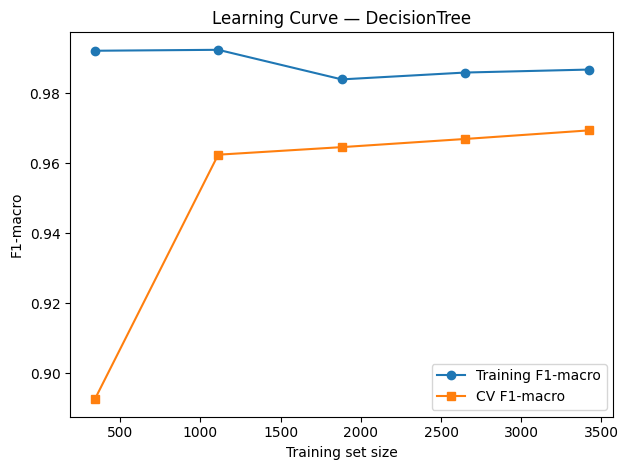

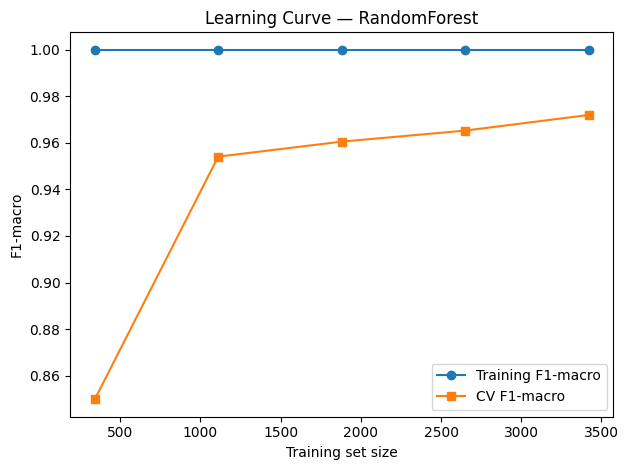

In [22]:
# learning curves
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
import numpy as np, matplotlib.pyplot as plt

top2 = results_df.sort_values(by='valid_macroF1', ascending=False).head(2)['name'].tolist()
for name in top2:
    m = best_estimators[name]
    pipe = m if hasattr(m, "get_params") else Pipeline([('clf', m)])
    train_sizes, train_scores, valid_scores = learning_curve(
        pipe, X_train, y_train, cv=5, scoring='f1_macro',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, shuffle=True, random_state=42
    )
    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Training F1-macro')
    plt.plot(train_sizes, valid_scores.mean(axis=1), marker='s', label='CV F1-macro')
    plt.xlabel('Training set size'); plt.ylabel('F1-macro')
    plt.title(f'Learning Curve — {name}')
    plt.legend(); plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'lc_{name}.png', dpi=150)
    plt.show()


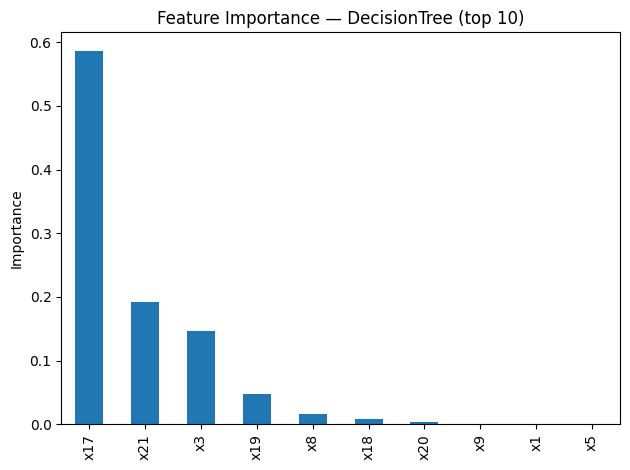

In [23]:
# importanza feature per gli alberi
import pandas as pd, matplotlib.pyplot as plt
feature_names = [f"x{i}" for i in range(1, 22)]
model = best_estimators["DecisionTree"].named_steps.get('clf')
importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
ax = importances.head(10).plot(kind='bar'); ax.set_ylabel('Importance'); ax.set_title('Feature Importance — DecisionTree (top 10)')
plt.tight_layout(); plt.savefig(RESULTS_DIR / 'featimp_decisiontree_top10.png', dpi=150); plt.show()
importances.to_csv(RESULTS_DIR / 'feature_importance_DecisionTree.csv')


,0
x17,0.587303
x21,0.350026
x3,0.053525
x19,0.024862
x8,0.009328
x18,0.005114
x20,0.003426
x2,0.000000
x1,0.000000
x5,0.000000


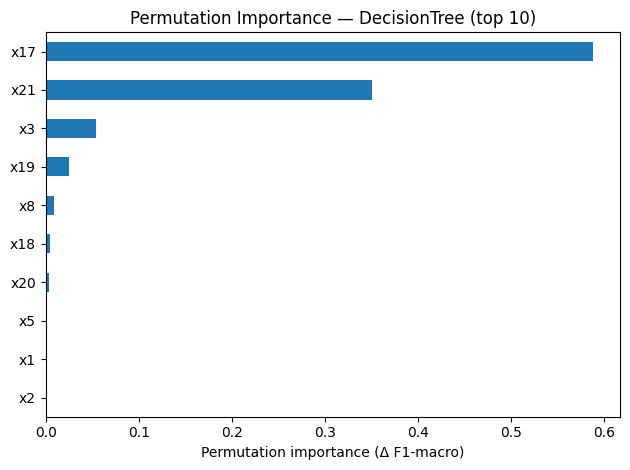

In [24]:
# Permutation Importance (validation, F1-macro)
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(exist_ok=True)

est = best_estimators["DecisionTree"]  # modello scelto
feature_names = [f"x{i}" for i in range(1, 22)]

r = permutation_importance(
    est, X_valid, y_valid,
    scoring='f1_macro', n_repeats=20, random_state=42
)

perm_series = pd.Series(r.importances_mean, index=feature_names).sort_values(ascending=False)
display(perm_series.head(10))

# salva CSV
perm_series.to_csv(RESULTS_DIR / "permutation_importance_decisiontree.csv")

# grafico top-10
top10 = perm_series.head(10).sort_values(ascending=True)
ax = top10.plot(kind='barh')
ax.set_xlabel("Permutation importance (Δ F1-macro)")
ax.set_title("Permutation Importance — DecisionTree (top 10)")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "permimp_decisiontree_top10.png", dpi=150)
plt.show()


In [25]:
# scarto standard
import pandas as pd

pd.DataFrame({
    "feature": [f"x{i}" for i in range(1,22)],
    "mean": r.importances_mean,
    "std":  r.importances_std
}).sort_values("mean", ascending=False).head(10)

,feature,mean,std
16,x17,0.587303,0.023682
20,x21,0.350026,0.016301
2,x3,0.053525,0.007652
18,x19,0.024862,0.005995
7,x8,0.009328,0.002836
17,x18,0.005114,0.001173
19,x20,0.003426,0.004882
1,x2,0.000000,0.000000
0,x1,0.000000,0.000000
4,x5,0.000000,0.000000



Confusion matrix VALIDATION per: GaussianNB


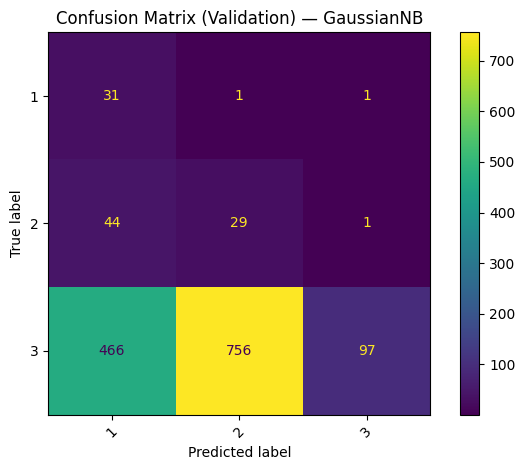


Confusion matrix VALIDATION per: SoftmaxRegression


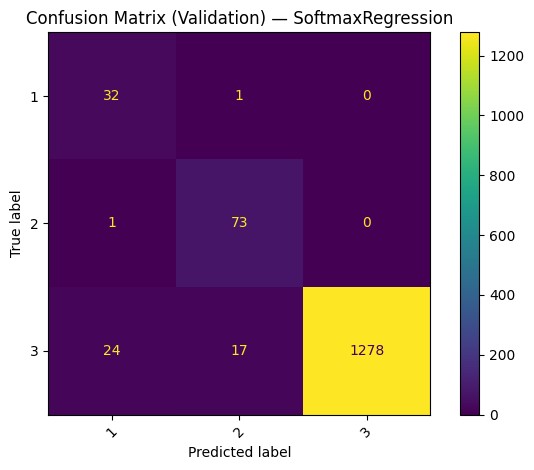


Confusion matrix VALIDATION per: DecisionTree


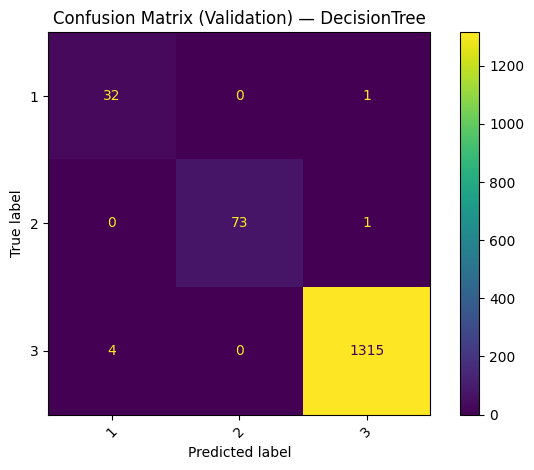


Confusion matrix VALIDATION per: RandomForest


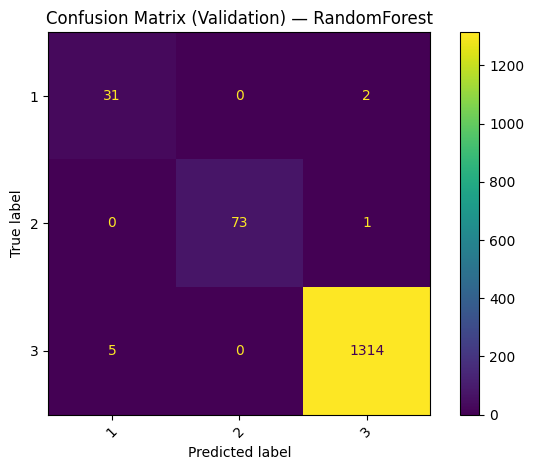


Confusion matrix VALIDATION per: SVM_Linear


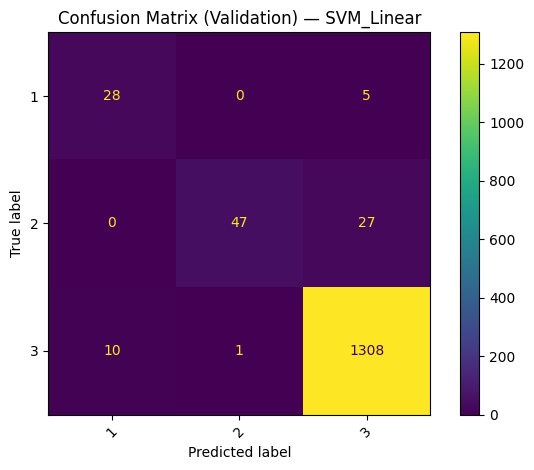


Confusion matrix VALIDATION per: SVM_RBF


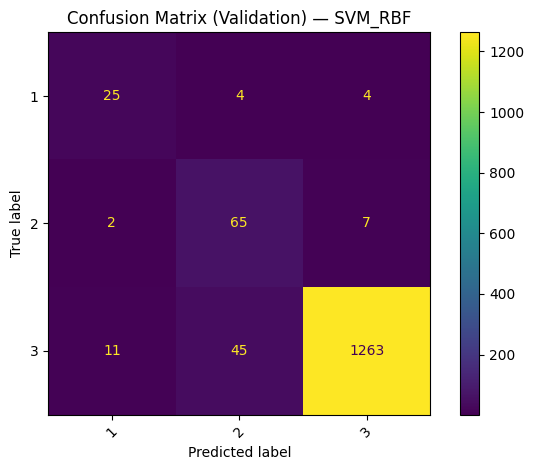

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

labels = np.sort(np.unique(y_train))

for name in models_of_interest:
    print("\n==============================")
    print(f"Confusion matrix VALIDATION per: {name}")
    est = best_estimators[name]

    y_pred_val = est.predict(X_valid)
    cm_val = confusion_matrix(y_valid, y_pred_val, labels=labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
    disp.plot(values_format='d', xticks_rotation=45)
    plt.title(f'Confusion Matrix (Validation) — {name}')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'cm_valid_{name}.png', dpi=150)
    plt.show()


In [27]:
from pathlib import Path
import pandas as pd, numpy as np, os, sys

ok = True
msgs = []

# 1) Check split
try:
    _ = (X_train.shape, X_valid.shape, X_test.shape)
    msgs.append(f"Split: train={X_train.shape[0]}, valid={X_valid.shape[0]}, test={X_test.shape[0]}")
except:
    ok=False; msgs.append("Manca lo split (X_train/X_valid/X_test).")

# 2) Check risultati comparativi
try:
    assert 'results_df' in globals() and not results_df.empty
    cols = {'name','valid_macroF1','test_macroF1','cv_best_macroF1','grid_time_sec'}
    assert cols.issubset(results_df.columns)
    top = results_df.sort_values('valid_macroF1', ascending=False).head(3)
    msgs.append("Top-3 valid_macroF1:\n" + top[['name','valid_macroF1','test_macroF1']].to_string(index=False))
except Exception as e:
    ok=False; msgs.append(f"Manca/è incompleto results_df: {e}")

# 3) Check immagini salvate
needed = [
    "cm_valid_", "cm_test_",
    "roc_valid_", "lc_", "feature_importance", "permimp_"
]
present = list(map(str, Path("results").glob("*")))
for tag in needed:
    if not any(tag in p for p in present):
        ok=False; msgs.append(f"⚠ Mancano file con prefisso '{tag}' in results/.")
msgs.append(f"File in results/: {len(present)}")

# 4) Check metriche macro-F1 vs accuracy (sanity per sbilanciamento)
try:
    assert top['valid_macroF1'].iloc[0] <= 1.0 and top['valid_macroF1'].iloc[0] >= 0.5
    msgs.append("Sanity macro-F1: valori plausibili.")
except:
    ok=False; msgs.append("Macro-F1 fuori range? Verifica calcolo/average='macro'.")

print("\n".join(msgs))
print("\nESITO:", "OK ✅" if ok else "RIVEDERE ⚠️")


Split: train=4277, valid=1426, test=1426
Top-3 valid_macroF1:
             name  valid_macroF1  test_macroF1
     DecisionTree       0.972819      0.980368
     RandomForest       0.962904      0.985202
SoftmaxRegression       0.860057      0.860731
File in results/: 38
Sanity macro-F1: valori plausibili.

ESITO: OK ✅


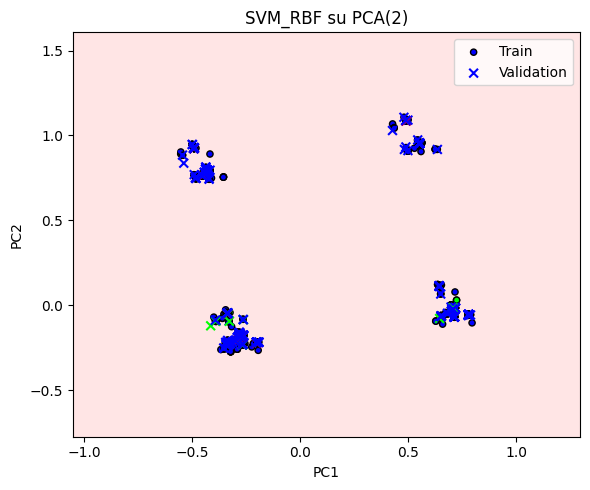

In [28]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# 1) PCA a 2 dimensioni su train+valid (solo per visualizzazione)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_2d = pca.fit_transform(X_train)
X_valid_2d = pca.transform(X_valid)

# 2) Allena un classificatore 2D (qui SVM RBF con parametri semplici)
clf_2d = SVC(kernel="rbf", gamma="scale", C=1.0, random_state=RANDOM_STATE)
clf_2d.fit(X_train_2d, y_train)

# 3) Funzione per plottare il decision boundary
def plot_decision_boundary_2d(model, X_tr, y_tr, X_val, y_val, title):
    x_min = min(X_tr[:, 0].min(), X_val[:, 0].min()) - 0.5
    x_max = max(X_tr[:, 0].max(), X_val[:, 0].max()) + 0.5
    y_min = min(X_tr[:, 1].min(), X_val[:, 1].min()) - 0.5
    y_max = max(X_tr[:, 1].max(), X_val[:, 1].max()) + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

    # punti train
    plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap=cmap_bold,
                edgecolor='k', s=20, label='Train')
    # punti validation
    plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cmap_bold,
                marker='x', s=40, label='Validation')

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"decision_boundary_{title.replace(' ', '_')}.png", dpi=150)
    plt.show()

plot_decision_boundary_2d(clf_2d, X_train_2d, y_train, X_valid_2d, y_valid,
                          "SVM_RBF su PCA(2)")


<Figure size 1600x1000 with 0 Axes>

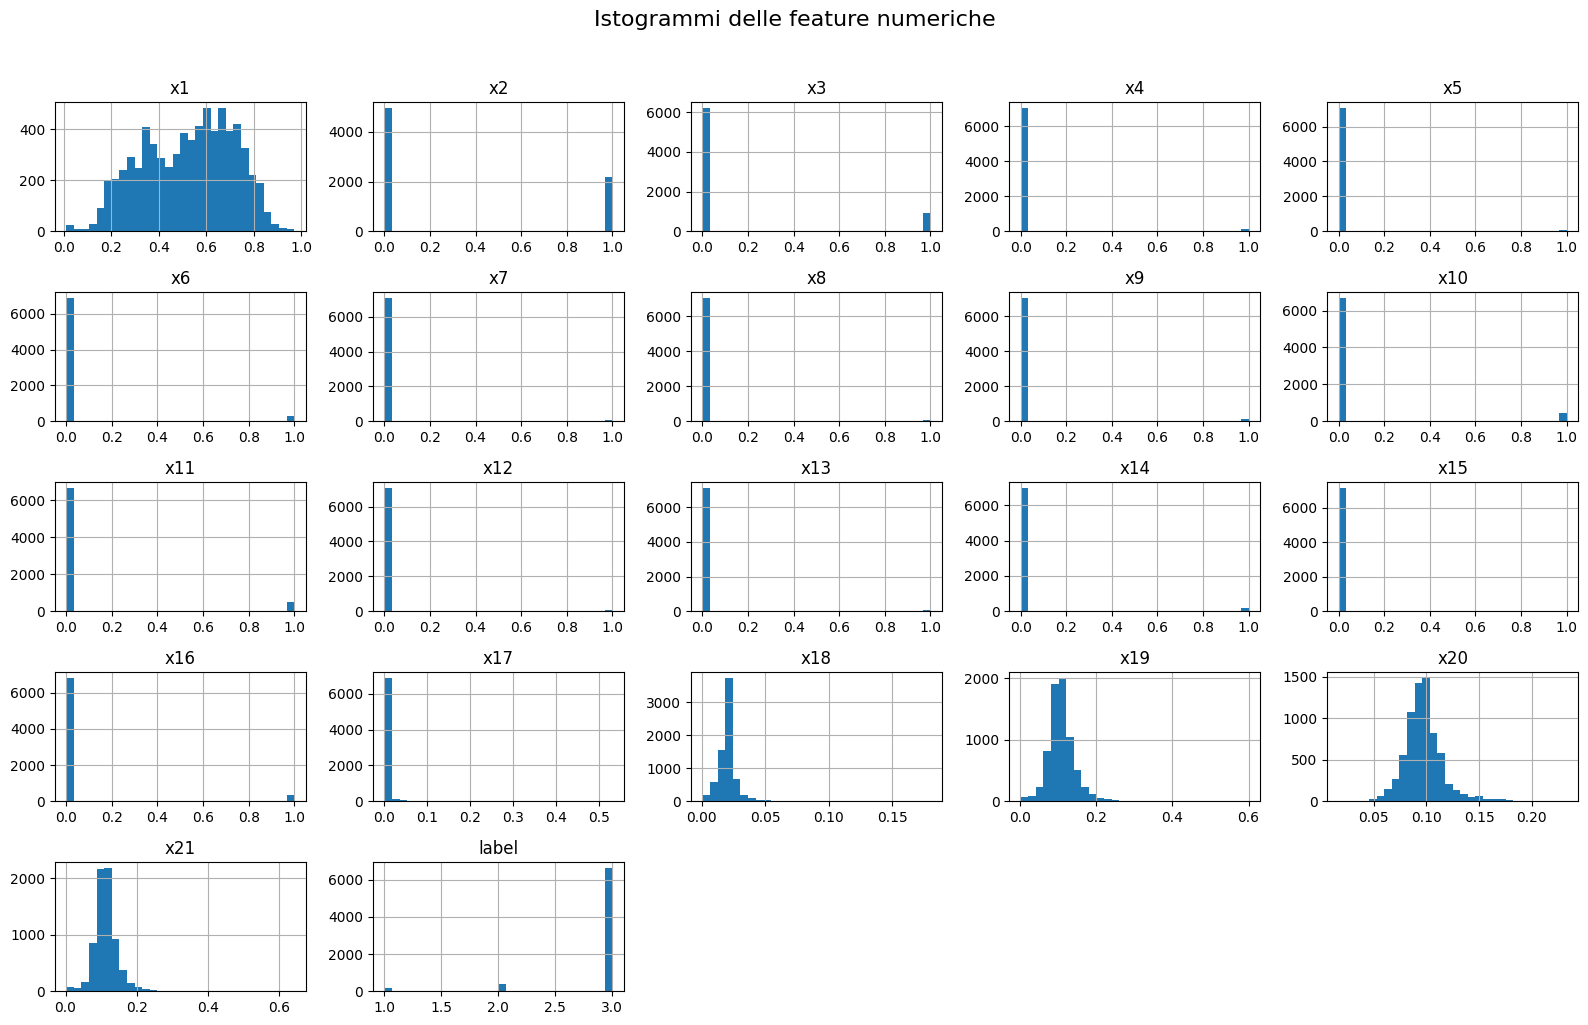

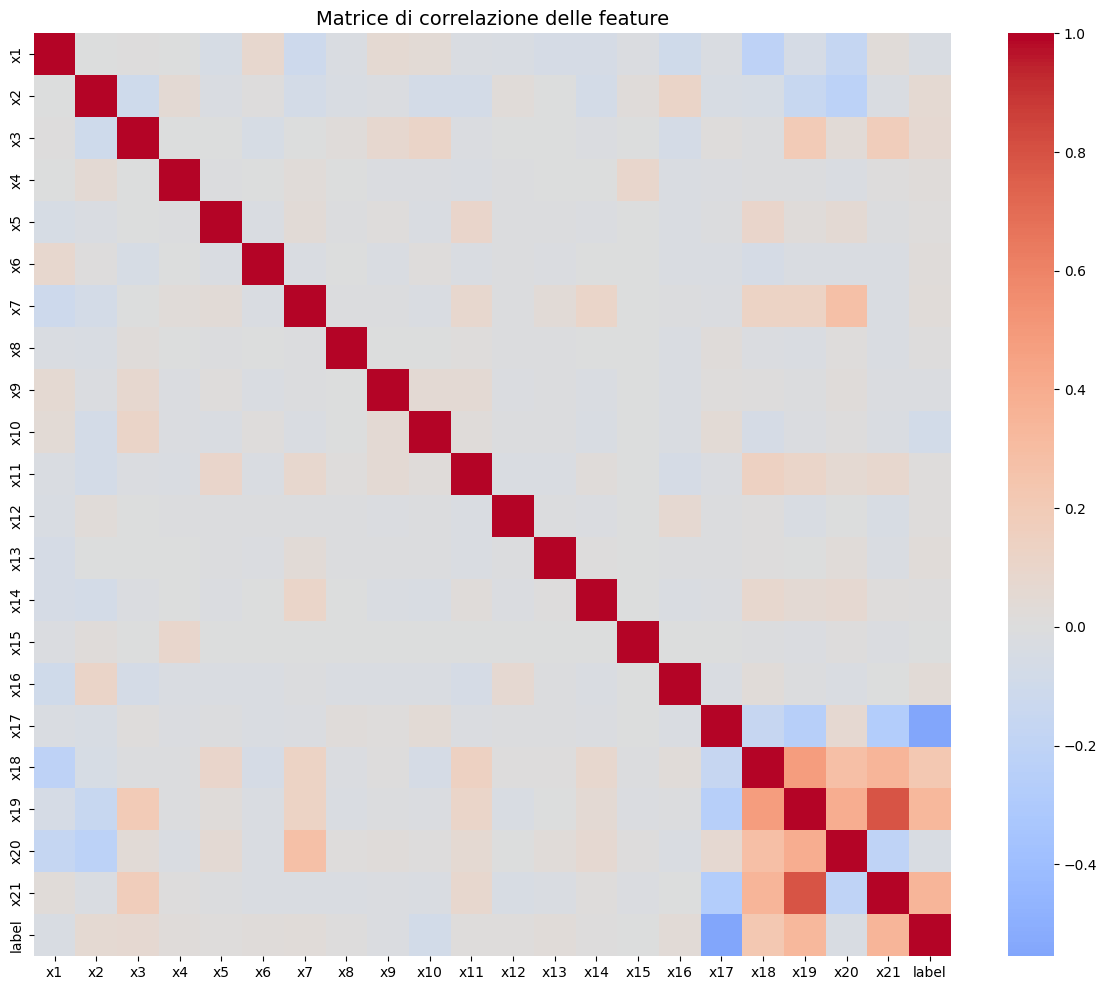

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleziono le colonne delle feature (tutte tranne la label)
feature_cols = df_clean.columns[:-1]

# --- Istogrammi delle feature ---
plt.figure(figsize=(16, 10))
df_clean[feature_cols].hist(bins=30, figsize=(16, 10))
plt.suptitle("Istogrammi delle feature numeriche", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# --- Matrice di correlazione ---
plt.figure(figsize=(12, 10))
corr = df_clean[feature_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matrice di correlazione delle feature", fontsize=14)
plt.tight_layout()
plt.show()


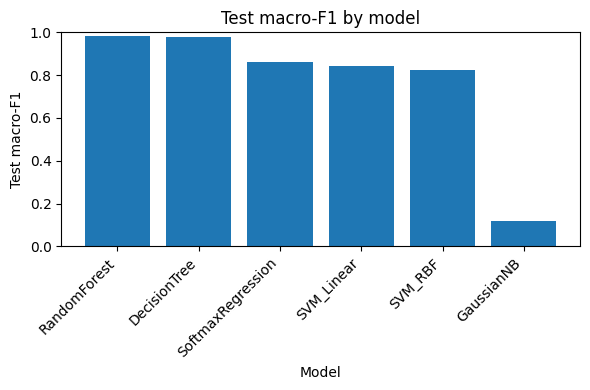

In [30]:
import matplotlib.pyplot as plt

# Partiamo da results_df già creato nella parte GridSearch
plot_df = results_df.sort_values(by="test_macroF1", ascending=False)

plt.figure(figsize=(6, 4))
plt.bar(plot_df["name"], plot_df["test_macroF1"])
plt.xlabel("Model")
plt.ylabel("Test macro-F1")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha="right")
plt.title("Test macro-F1 by model")
plt.tight_layout()

plt.savefig(RESULTS_DIR / "model_macro_f1_test.png",
            dpi=300, bbox_inches="tight")
plt.show()
